# KNN - BINARY CLASSIFICATION 

## "is_from_North America"

In [247]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [248]:
train_df = pd.read_csv("pp_train.csv")
test_df = pd.read_csv("pp_test.csv")

copy_train = train_df.copy()
copy_test = test_df.copy()

In [249]:
copy_train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'countryOfOrigin', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryO

In [250]:
copy_test.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Western', 'is_Thriller', 'is_Horror', 'is_Animation', 'is_Family',
       'is_News', 'is_Sport', 'is_Reality-TV', 'is_Biography', 'is_Sci-Fi',
       'is_Fantasy', 'is_Documentary', 'is_Talk-Show', 'is_Drama', 'is_Music',
       'is_Game-Show', 'is_Adventure', 'is_Romance', 'is_Mystery', 'is_Short',
       'is_Action', 'is_Adult', 'is_History', 'is_Musical', 'is_Crime',
       'is_Film-Noir', 'is_War', 'is_Comedy', 'fill_runtimeMinutes',
       'is_from_South America', 'is_from_Oceania', 'is_from_Europe',
       'is_from_Asia', 'is_from_Africa', 'is_from_North America',
       'countryOfOrigin', 'countryOfOrigin_freq_enc', 'countryOfOrigin_NA',
       'countryOfOrigin_AF', 'countryO

### Filtra il dataset sulle classi meno rappresentate --> 'videoGame': 1, 'tvMiniSeries': 5, 'tvSpecial': 8, 'tvShort': 9

In [251]:
# copy_train = copy_train[~copy_train['titleType'].isin(["videoGame", "tvMiniSeries", "tvSpecial", "tvShort"])]
# copy_test = copy_test[~copy_test['titleType'].isin(["videoGame", "tvMiniSeries", "tvSpecial", "tvShort"])]

### Selezione variabile target

In [252]:
y_train = np.array(copy_train['is_from_North America'])  # Il target originale
y_test = np.array(copy_test["is_from_North America"])

### Slight preprocessing delle variabili del dataset

In [253]:
copy_train["canHaveEpisodes"] = copy_train["canHaveEpisodes"].astype(int)
copy_test["canHaveEpisodes"] = copy_test["canHaveEpisodes"].astype(int)

In [254]:
copy_train = copy_train.drop(["originalTitle", "runtimeMinutes"], axis=1)
copy_test = copy_test.drop(["originalTitle", "runtimeMinutes"], axis=1)

In [255]:
copy_train = copy_train.drop(["endYear"], axis=1)
copy_test = copy_test.drop(["endYear"], axis=1)

### Selezione variabili per la classificazione

In [256]:
selected_var_tr = copy_train[['startYear', 'awardWins', 'numVotes', 
       'totalImages', 'totalCredits', "totalVideos", 
       'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal', 
       "fill_runtimeMinutes", 
       "rating", 
       #'is_from_Oceania', 'is_from_Europe','is_from_Asia', 'is_from_Africa', 'is_from_North America'
       ]].values

selected_var_ts = copy_test[['startYear', 'awardWins', 'numVotes', 
       'totalImages', 'totalCredits', "totalVideos", 
       'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal',
       "fill_runtimeMinutes", 
       "rating", 
       # 'is_from_Oceania', 'is_from_Europe', 'is_from_Asia', 'is_from_Africa', 'is_from_North America'
       ]].values

### Splitting in train-validation

In [257]:
X_train2, X_val, y_train2, y_val = train_test_split(
     selected_var_tr, y_train, test_size=0.2, random_state=32
)

# X_train2 = training set --> 80% di X_train
# X_val = validation set --> 20% di X_train
# y_train2 e y_val sono i target corrispondenti (etichette) per i dati di addestramento e validazione

### Normalizzazione

In [258]:
selected_var_tr_log = np.log1p(selected_var_tr)
X_train2_numeric_log = np.log1p(X_train2)
X_val_numeric_log = np.log1p(X_val)

X_test_numeric_log = np.log1p(selected_var_ts)

In [259]:
scaler = StandardScaler()

# # Fittiamo SOLO su train e trasformiamo tutto
X_train_standardsc = scaler.fit_transform(selected_var_tr_log)
X_train2_standardsc = scaler.fit_transform(X_train2_numeric_log)
X_val_standardsc = scaler.fit_transform(X_val_numeric_log)

X_test_standardsc = scaler.transform(X_test_numeric_log)


In [260]:
minmax = MinMaxScaler()

# # Fitta e trasforma il training set in un solo passaggio
X_train_minmax = minmax.fit_transform(selected_var_tr_log)
X_train2_minmax = minmax.fit_transform(X_train2_numeric_log)
X_val_minmax = minmax.fit_transform(X_val_numeric_log)

X_test_minmax = minmax.transform(X_test_numeric_log)

### KNN 

### RandomizedSearch per la selezione dei parametri

In [261]:
# import numpy as np
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# from sklearn.metrics import accuracy_score

# def optimize_knn_with_external_validation(X_train, y_train, X_val, y_val, n_iter=100, cv=5, verbose=1):
#     # Calcolo range k
#     sqrt_n = int(np.sqrt(X_train.shape[0]))
    
#     param_distributions = {
#         "n_neighbors": np.arange(1, sqrt_n + 1),
#         "weights": ["uniform", "distance"],
#         "metric": ["euclidean", "cityblock"]
#     }
    
#     random_search = RandomizedSearchCV(
#         KNeighborsClassifier(),
#         param_distributions=param_distributions,
#         n_iter=n_iter,
#         cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
#         n_jobs=-1,
#         refit=True,
#         random_state=42,
#         verbose=verbose,
#         scoring='accuracy',
#         return_train_score=True
#     )

#     # Fit solo sul training set
#     random_search.fit(X_train, y_train)
# #
#     # Valutazione su validation set
#     best_model = random_search.best_estimator_
#     y_val_pred = best_model.predict(X_val)
#     val_accuracy = accuracy_score(y_val, y_val_pred)

#     # Mostra le top 5 configurazioni (sulla cross-validation)
#     results = random_search.cv_results_
#     sorted_idx = np.argsort(results['rank_test_score'])
#     print("\nTop 5 configurations (CV scores):")
#     for i in range(5):
#         idx = sorted_idx[i]
#         print(f"Rank {i+1}: {results['params'][idx]}")
#         print(f"   CV Test score: {results['mean_test_score'][idx]:.4f}")
#         print(f"   CV Train score: {results['mean_train_score'][idx]:.4f}")

#     print(f"\nValidation Accuracy of Best Model: {val_accuracy:.4f}")

#     return best_model, random_search.best_params_, val_accuracy

### Da runnare sui risultati del RandomizedSearch

In [262]:
# # best_knn, best_params, best_score = optimize_knn(X_train2_standardsc, y_train2)

# best_knn, best_params, val_score = optimize_knn_with_external_validation(
#     X_train2_standardsc, y_train2, X_val_standardsc, y_val)


# # # Create a new classifier with the optimized parameters
# clf = KNeighborsClassifier(**best_params)
# clf.fit(X_train2_standardsc, y_train2)

# y_pred = clf.predict(X_val_standardsc)

### Da runnare se si ha già una configurazione accettabile

In [263]:
clf = KNeighborsClassifier(weights = 'uniform', n_neighbors= 27 , metric = 'cityblock')
clf.fit(X_train2_standardsc, y_train2)

y_pred = clf.predict(X_val_standardsc)

### Results of the prediction on the validation set

In [264]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.7372488408037094

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      1693
           1       0.74      0.69      0.71      1542

    accuracy                           0.74      3235
   macro avg       0.74      0.74      0.74      3235
weighted avg       0.74      0.74      0.74      3235



Performance sul Training set:
Accuracy: 0.7505
F1 Score: 0.7499

Performance sul Validation set:
Accuracy: 0.7372
F1 Score: 0.7366


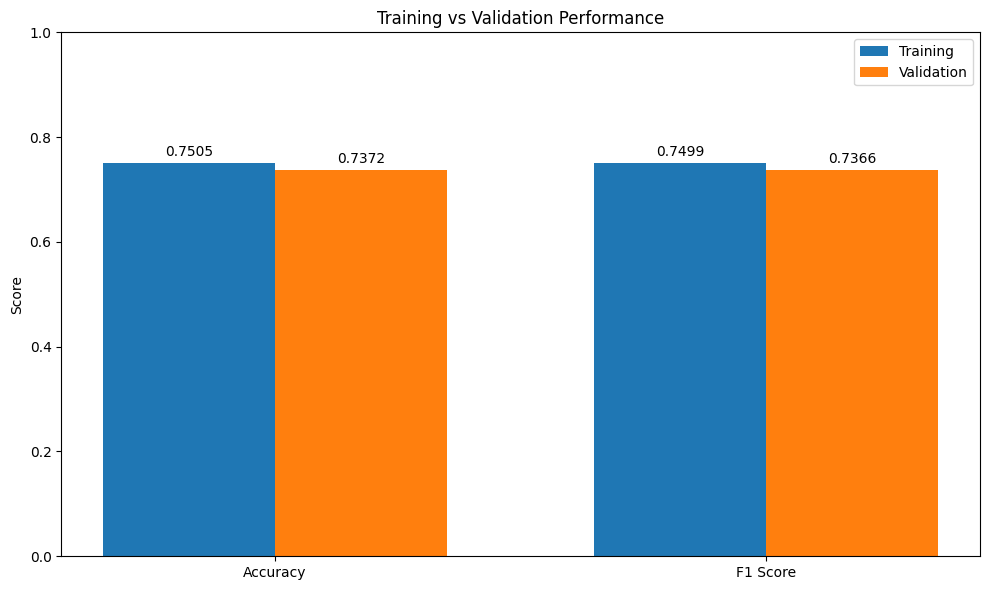

In [265]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_standardsc)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_standardsc)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

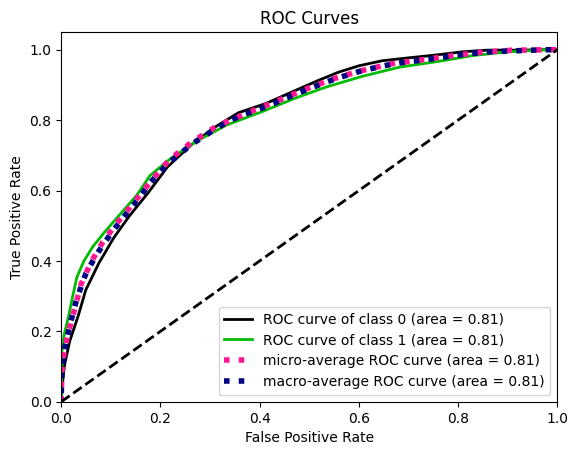

In [266]:
y_val_pred_proba = clf.predict_proba(X_val_standardsc)
plot_roc(y_val, y_val_pred_proba)
plt.show()

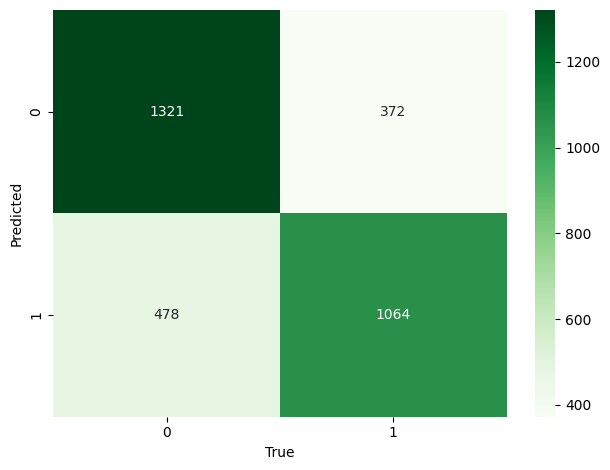

In [267]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

### Proper testing on the test set (once getting the right hyperparameters)

In [268]:
clf = KNeighborsClassifier(weights = 'uniform', n_neighbors= 27, metric = 'cityblock')
clf.fit(X_train_standardsc, y_train)

y_pred = clf.predict(X_test_standardsc)

Performance sul Training set:
Accuracy: 0.7507
F1 Score: 0.7502

Performance sul Test set:
Accuracy: 0.7372
F1 Score: 0.7366


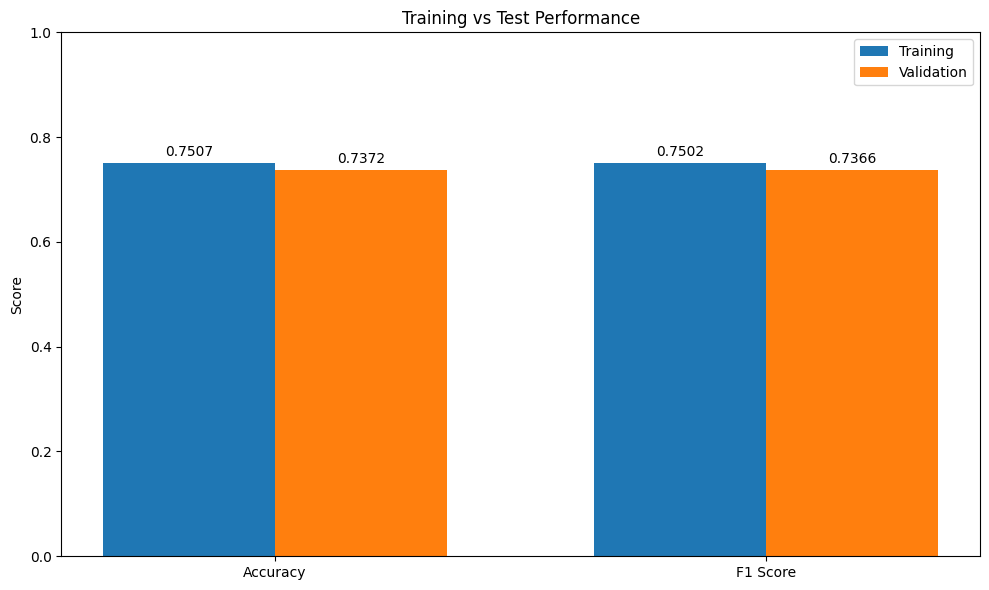

In [269]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_standardsc)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_standardsc)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Test set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [270]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.7312407132243685

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      2844
           1       0.73      0.69      0.71      2540

    accuracy                           0.73      5384
   macro avg       0.73      0.73      0.73      5384
weighted avg       0.73      0.73      0.73      5384



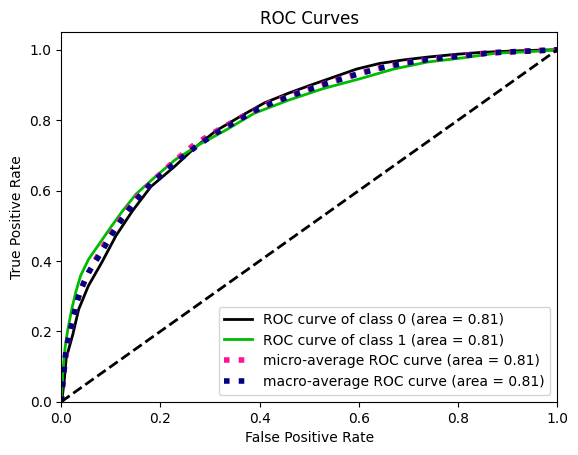

In [271]:
y_test_pred_proba = clf.predict_proba(X_test_standardsc)
plot_roc(y_test, y_test_pred_proba)
plt.show()

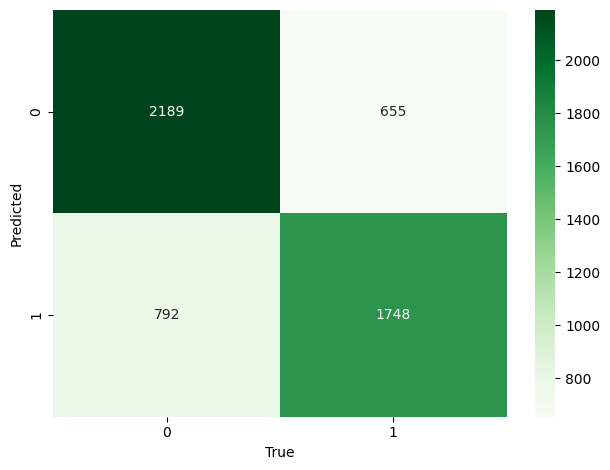

In [272]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

### Compare the results with a dummy classifier

In [273]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_standardsc, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_standardsc)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5282317979197623
Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69      2844
           1       0.00      0.00      0.00      2540

    accuracy                           0.53      5384
   macro avg       0.26      0.50      0.35      5384
weighted avg       0.28      0.53      0.37      5384



C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## "is_LowRated"

il problema è che ci sono pochi record con rating <= 5 quindi modello non performerebbe bene

In [274]:
# Create new binary variable
copy_train['is_LowRated'] = copy_train['rating'].isin([1, 2, 3, 4, 5]).astype(int)
copy_test['is_LowRated'] = copy_test['rating'].isin([1, 2, 3, 4, 5]).astype(int)

In [275]:
copy_train

,rating,startYear,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,titleType,awardNominationsExcludeWins,...,countryOfOrigin_AS,countryOfOrigin_EU,countryOfOrigin_OC,countryOfOrigin_SA,countryOfOrigin_UNK,fill_runtimeMinutes_Bruno,totalNominations,totalMedia,runtimeMinutes_notitletype,is_LowRated
0,8,1995,0.0,779,1,0,21,1,tvEpisode,0,...,0,0,0,0,0,29.0,0.0,1,NaN,0
1,6,1992,0.0,38,1,0,24,0,movie,0,...,0,1,0,0,0,94.0,0.0,1,NaN,0
2,6,2021,0.0,15,22,0,56,0,tvSeries,0,...,0,0,0,0,0,30.0,0.0,22,60.0,0
3,8,2020,1.0,15718,347,2,47,4,tvSeries,1,...,1,0,0,0,0,80.0,2.0,349,80.0,0
4,9,1995,0.0,14,1,0,0,0,video,0,...,0,0,0,0,0,34.0,0.0,1,34.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16167,6,1942,0.0,73,4,0,45,1,movie,0,...,0,1,0,0,0,85.0,0.0,4,NaN,0
16168,5,1990,0.0,15,2,0,22,0,movie,0,...,1,0,0,0,0,86.0,0.0,2,NaN,1
16169,6,2021,0.0,2560,39,3,129,0,movie,5,...,1,0,0,0,0,140.0,5.0,42,140.0,0
16170,4,1982,0.0,3011,52,1,53,55,movie,0,...,0,1,0,0,0,94.0,0.0,53,NaN,1


In [276]:
x = sum(copy_train["is_LowRated"]  == 1)
x

1813

## "has_lowEngagement"

In [277]:
copy_train['has_lowEngagement'] = (copy_train['numVotes'] < 100).astype(int)
copy_test['has_lowEngagement'] = (copy_test['numVotes'] < 100).astype(int)

In [278]:
x = sum(copy_train["has_lowEngagement"] == 1)
x

11105

### Selezione variabile target

In [279]:
y_train = np.array(copy_train['has_lowEngagement'])  # Il target originale
y_test = np.array(copy_test["has_lowEngagement"])

### Selezione attributi per la classificazione

In [280]:
# VAR USATE NEL PRIMO TENTATIVO (vedi file KNN sul drive)
# selected_var_tr = copy_train[['startYear', 'awardWins', 'numVotes', 
#        'totalImages', 'totalCredits', "totalVideos", 
#        'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
#        'numRegions', 'userReviewsTotal', 
#        "fill_runtimeMinutes", 
#        "rating", 
#        #'is_from_Oceania', 'is_from_Europe','is_from_Asia', 'is_from_Africa', 'is_from_North America'
#        ]].values

selected_var_tr = copy_train[['startYear', 'numVotes', 'totalNominations', 'totalMedia', 
       'totalCredits', 'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal', 
       #"fill_runtimeMinutes",
       'fill_runtimeMinutes_Bruno',
       #'runtimeMinutes_notitletype',
       "rating", 
       #'is_from_Oceania', 'is_from_Europe','is_from_Asia', 'is_from_Africa', 'is_from_North America'
       ]].values

# VAR USATE NEL PRIMO TENTATIVO (vedi file KNN sul drive)
# selected_var_ts = copy_test[['startYear', 'awardWins', 'numVotes', 
#        'totalImages', 'totalCredits', "totalVideos", 
#        'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
#        'numRegions', 'userReviewsTotal',
#        "fill_runtimeMinutes", 
#        "rating", 
#        #'is_from_Oceania', 'is_from_Europe', 'is_from_Asia', 'is_from_Africa', 'is_from_North America'
#        ]].values

selected_var_ts = copy_test[['startYear', 'numVotes', 'totalNominations', 'totalMedia', 
       'totalCredits', 'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal',
       #"fill_runtimeMinutes",
       'fill_runtimeMinutes_Bruno',
       #'runtimeMinutes_notitletype',
       "rating", 
       #'is_from_Oceania', 'is_from_Europe', 'is_from_Asia', 'is_from_Africa', 'is_from_North America'
       ]].values

### Splitting in train-validation

In [281]:
X_train2, X_val, y_train2, y_val = train_test_split(
     selected_var_tr, y_train, test_size=0.2, random_state=32
)

In [282]:
selected_var_tr_log = np.log1p(selected_var_tr)
X_train2_numeric_log = np.log1p(X_train2)
X_val_numeric_log = np.log1p(X_val)

X_test_numeric_log = np.log1p(selected_var_ts)

In [283]:
scaler = StandardScaler()

# # Fittiamo SOLO su train e trasformiamo tutto
X_train_standardsc = scaler.fit_transform(selected_var_tr_log)
X_train2_standardsc = scaler.fit_transform(X_train2_numeric_log)
X_val_standardsc = scaler.fit_transform(X_val_numeric_log)

X_test_standardsc = scaler.transform(X_test_numeric_log)

In [284]:
minmax = MinMaxScaler()

# # Fitta e trasforma il training set in un solo passaggio
X_train_minmax = minmax.fit_transform(selected_var_tr_log)
X_train2_minmax = minmax.fit_transform(X_train2_numeric_log)
X_val_minmax = minmax.fit_transform(X_val_numeric_log)

X_test_minmax = minmax.transform(X_test_numeric_log)

### RandomizedSearch

In [285]:
# import numpy as np
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# from sklearn.metrics import accuracy_score

# def optimize_knn_with_external_validation(X_train, y_train, X_val, y_val, n_iter=100, cv=5, verbose=1):
#     # Calcolo range k
#     sqrt_n = int(np.sqrt(X_train.shape[0]))
    
#     param_distributions = {
#         "n_neighbors": np.arange(1, sqrt_n + 1),
#         "weights": ["uniform", "distance"],
#         "metric": ["euclidean", "cityblock"]
#     }
    
#     random_search = RandomizedSearchCV(
#         KNeighborsClassifier(),
#         param_distributions=param_distributions,
#         n_iter=n_iter,
#         cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
#         n_jobs=-1,
#         refit=True,
#         random_state=42,
#         verbose=verbose,
#         scoring='accuracy',
#         return_train_score=True
#     )

#     # Fit solo sul training set
#     random_search.fit(X_train, y_train)
# #
#     # Valutazione su validation set
#     best_model = random_search.best_estimator_
#     y_val_pred = best_model.predict(X_val)
#     val_accuracy = accuracy_score(y_val, y_val_pred)

#     # Mostra le top 5 configurazioni (sulla cross-validation)
#     results = random_search.cv_results_
#     sorted_idx = np.argsort(results['rank_test_score'])
#     print("\nTop 5 configurations (CV scores):")
#     for i in range(5):
#         idx = sorted_idx[i]
#         print(f"Rank {i+1}: {results['params'][idx]}")
#         print(f"   CV Test score: {results['mean_test_score'][idx]:.4f}")
#         print(f"   CV Train score: {results['mean_train_score'][idx]:.4f}")

#     print(f"\nValidation Accuracy of Best Model: {val_accuracy:.4f}")

#     return best_model, random_search.best_params_, val_accuracy

In [286]:
# # best_knn, best_params, best_score = optimize_knn(X_train2_standardsc, y_train2)

# best_knn, best_params, val_score = optimize_knn_with_external_validation(
#     X_train2_standardsc, y_train2, X_val_standardsc, y_val)


# # # Create a new classifier with the optimized parameters
# clf = KNeighborsClassifier(**best_params)
# clf.fit(X_train2_standardsc, y_train2)

# y_pred = clf.predict(X_val_standardsc)

### Prediction on the validation set

In [287]:
clf = KNeighborsClassifier(weights = 'uniform', n_neighbors= 8 , metric = 'cityblock')
clf.fit(X_train2_standardsc, y_train2)

y_pred = clf.predict(X_val_standardsc)

In [288]:
print(f"Validation accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Validation accuracy: 0.9505409582689336

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1014
           1       0.96      0.97      0.96      2221

    accuracy                           0.95      3235
   macro avg       0.95      0.94      0.94      3235
weighted avg       0.95      0.95      0.95      3235



Performance sul Training set:
Accuracy: 0.9638
F1 Score: 0.9638

Performance sul Validation set:
Accuracy: 0.9505
F1 Score: 0.9503


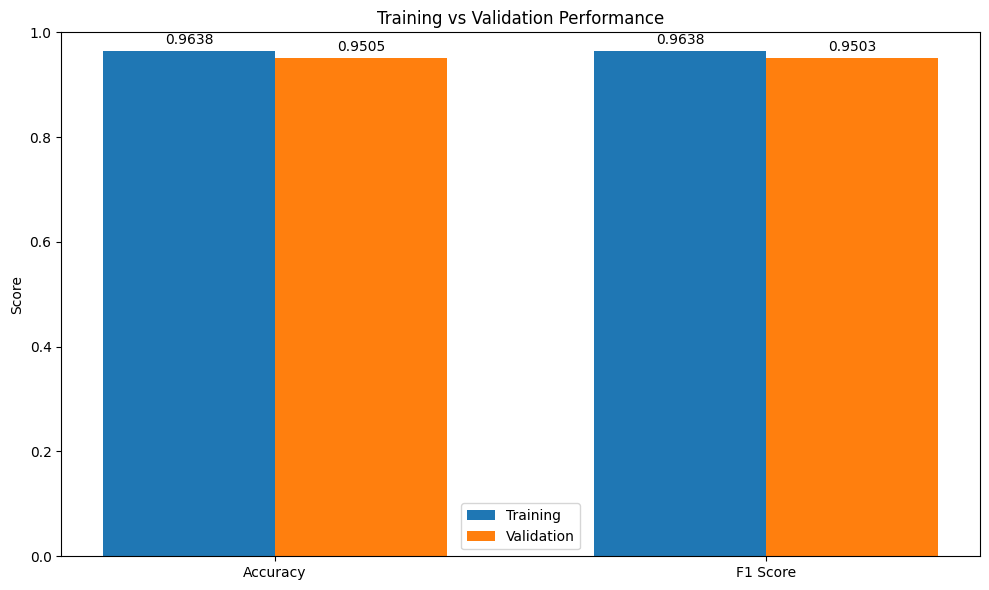

In [289]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_standardsc)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_standardsc)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

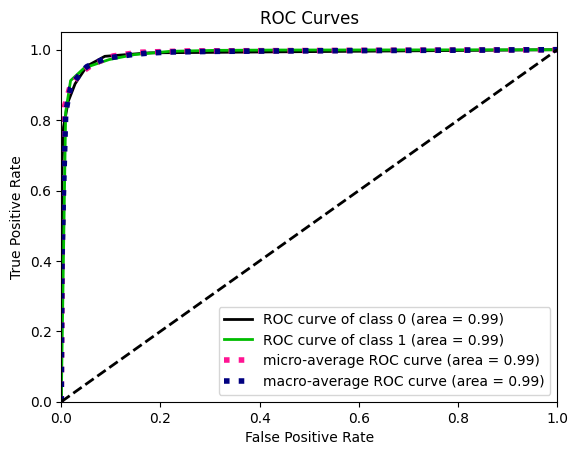

In [290]:
y_val_pred_proba = clf.predict_proba(X_val_standardsc)
plot_roc(y_val, y_val_pred_proba)
plt.show()

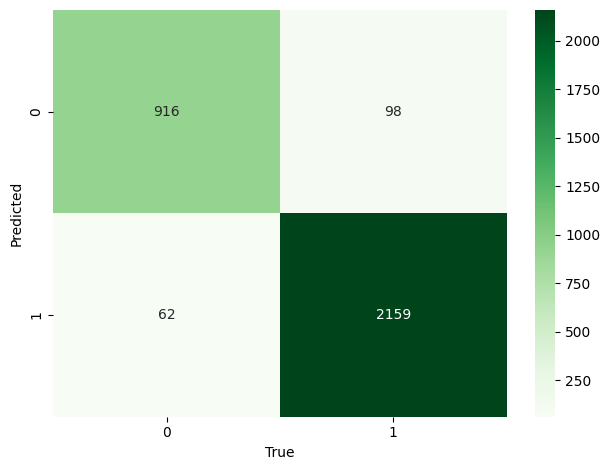

In [291]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

### Prediction on the test set

In [292]:
clf = KNeighborsClassifier(weights = 'uniform', n_neighbors= 8, metric = 'cityblock')
clf.fit(X_train_standardsc, y_train)

y_pred = clf.predict(X_test_standardsc)

Performance sul Training set:
Accuracy: 0.9664
F1 Score: 0.9663

Performance sul Test set:
Accuracy: 0.9505
F1 Score: 0.9503


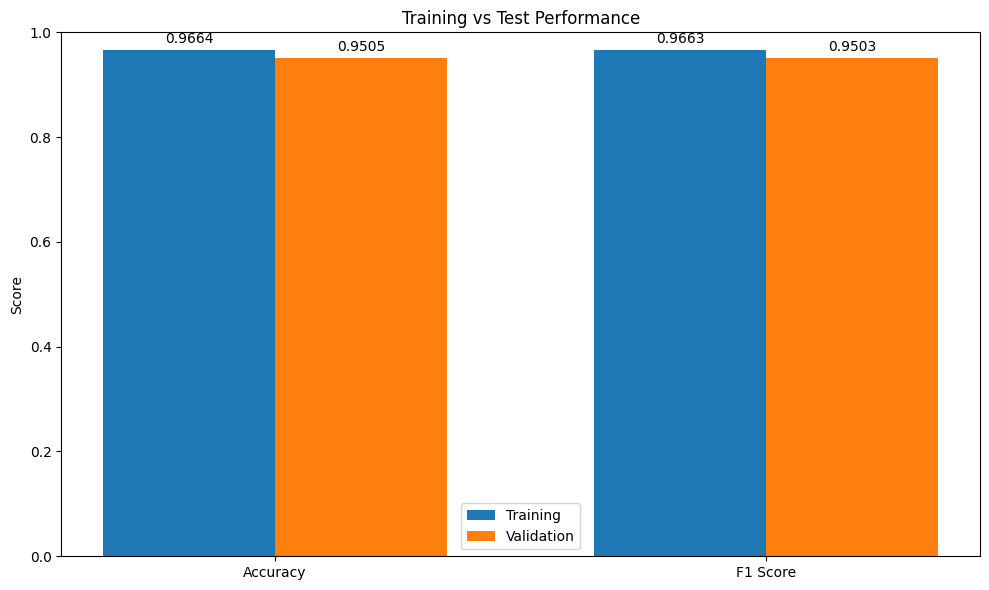

In [293]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_standardsc)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_standardsc)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Test set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [294]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.950965824665676

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1698
           1       0.96      0.97      0.96      3686

    accuracy                           0.95      5384
   macro avg       0.95      0.94      0.94      5384
weighted avg       0.95      0.95      0.95      5384



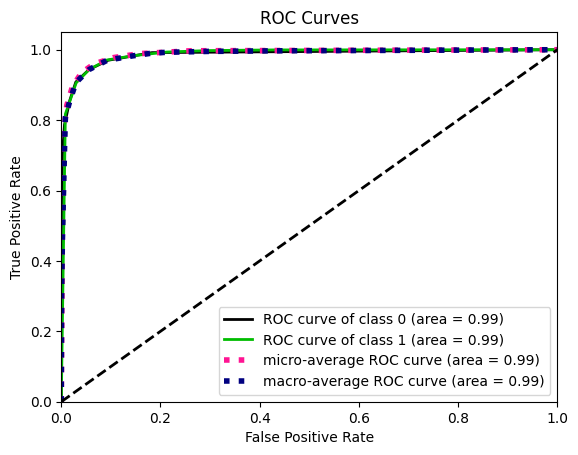

In [295]:
y_test_pred_proba = clf.predict_proba(X_test_standardsc)
plot_roc(y_test, y_test_pred_proba)
plt.show()

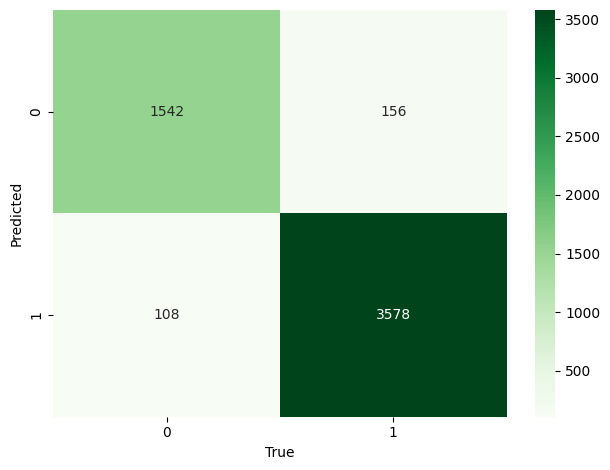

In [296]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

### Compare the results with a dummy classifier

In [297]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_standardsc, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_standardsc)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6846210995542348
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1698
           1       0.68      1.00      0.81      3686

    accuracy                           0.68      5384
   macro avg       0.34      0.50      0.41      5384
weighted avg       0.47      0.68      0.56      5384



C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
